<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrames

We finished the last section by building a parallel dataframe computation over a directory of CSV files using `dask.delayed`.  In this section we use `dask.dataframe` to build computations for us in the common case of tabular computations.  Dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers `dask.delayed`.

In this notebook we use the same airline data as in notebook 01, but now rather than write for loops we let `dask.dataframe` construct our computations for us.  The `dask.dataframe.read_csv` function can take a globstring like `"data/nycflights/*.csv"` and build parallel computations on all of our data at once.

In [6]:
ls

01-dask.delayed.ipynb
02-dask-dataframes.ipynb
03-schedulers.ipynb
04-distributed-dataframes-and-efficiency.ipynb
05-dask-ecosystem.ipynb
README.md
data/
prep_data.py
solutions/


In [7]:
import os

import dask
import dask.dataframe as dd

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

In [8]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
None,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
# Get the first 5 rows
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [10]:
# Get the last 5 rows
df.tail()

ValueError: could not convert string to float: N539UA

### What just happened?

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns. 

In [11]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [12]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## Computations with `dask.dataframe`

We compute the maximum of the `DepDelay` column.  With `dask.delayed` we could create this computation as follows:

```python
maxes = []
for fn in filenames:
    df = dask.delayed(pd.read_csv)(fn)
    maxes.append(df.DepDelay.max())
    
final_max = dask.delayed(max)(maxes)
final_max.compute()
```

Now we just use the normal Pandas syntax as follows:

In [13]:
%time df.DepDelay.max().compute()

CPU times: user 10.6 s, sys: 2.68 s, total: 13.2 s
Wall time: 6.61 s


1435.0

This writes the delayed computation for us and then runs it.  

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:/

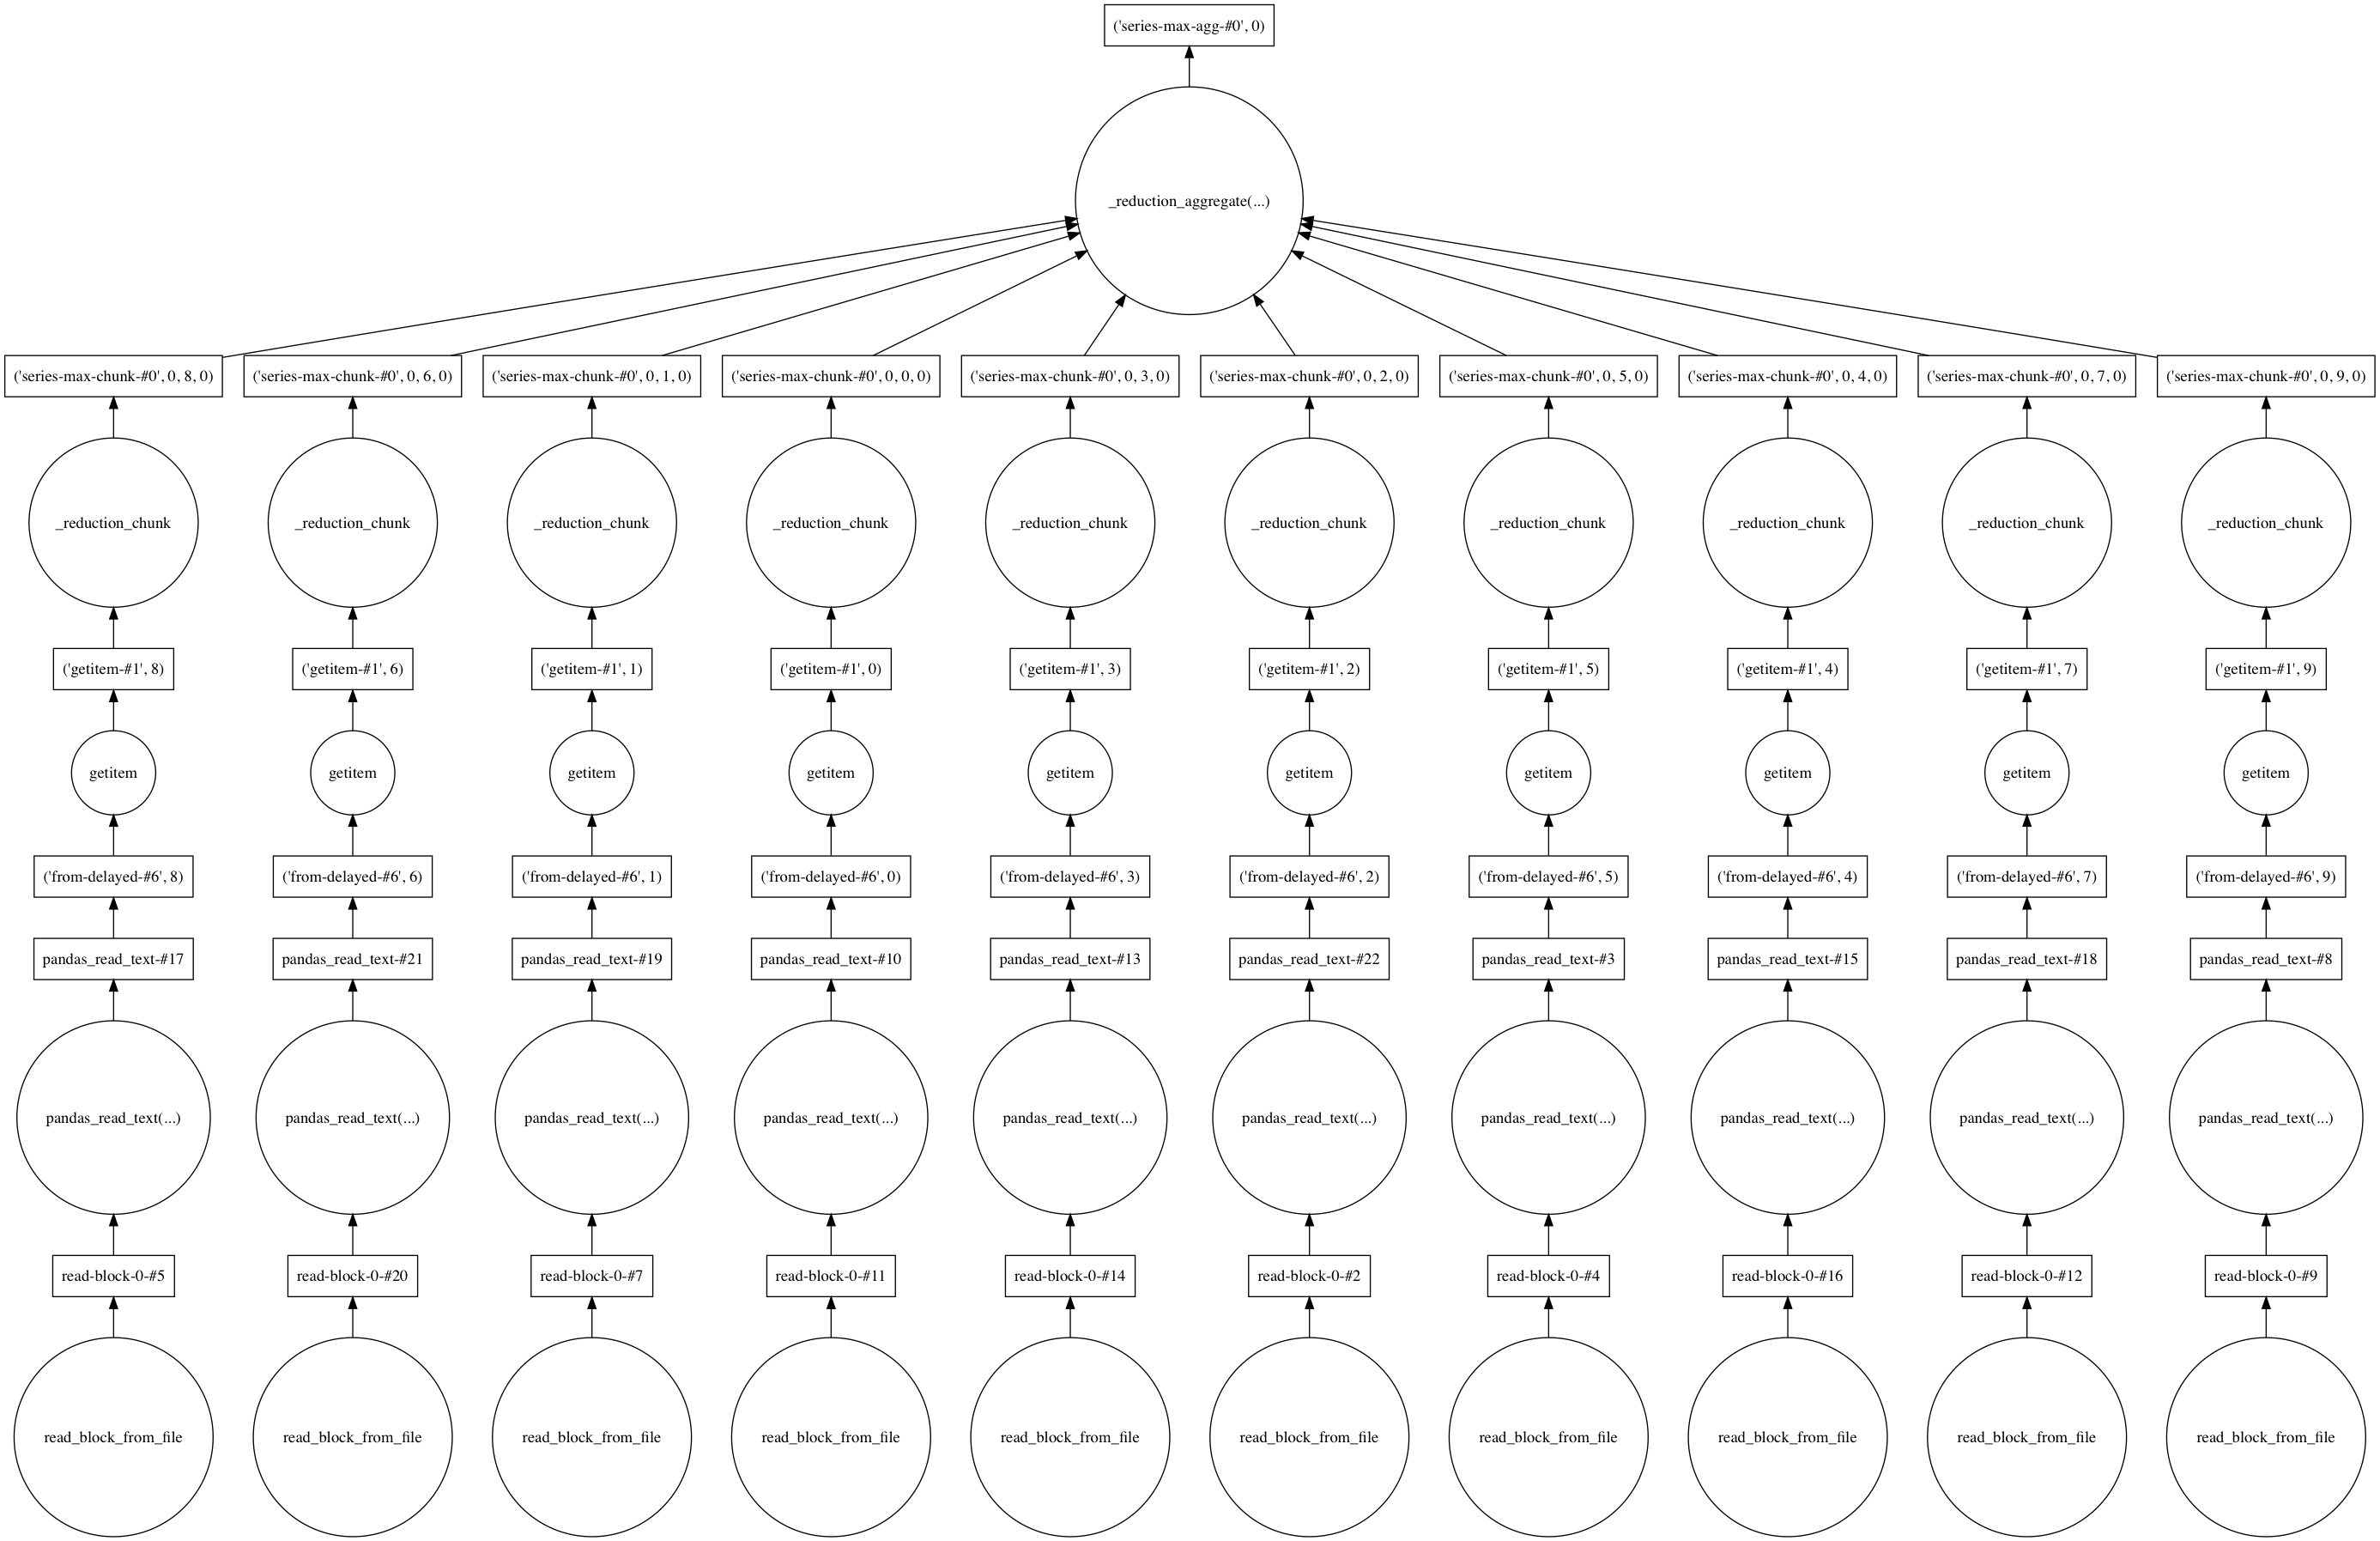

In [14]:
df.DepDelay.max().visualize()

## Exercises

In this section we do a few `dask.dataframe` computations. If you are comfortable with Pandas then these should be familiar. You will have to think about when to call `compute`.

### 1.) How many rows are in our dataset?

In [18]:
%%time
len(df)

CPU times: user 10.5 s, sys: 2.89 s, total: 13.4 s
Wall time: 6.95 s


2611892

<button data-toggle="collapse" data-target="#sol3" class='btn btn-primary'>Solution</button>
<div id="sol3" class="collapse">
```python
len(df)
```

### 2.) In total, how many non-cancelled flights were taken?

In [25]:
%%time

len(df[df['Cancelled'] == False])

CPU times: user 10.5 s, sys: 2.93 s, total: 13.4 s
Wall time: 7.11 s


2540961

In [26]:
%%time
len(df[~df.Cancelled])

CPU times: user 10.5 s, sys: 3.02 s, total: 13.5 s
Wall time: 7.18 s


2540961

<button data-toggle="collapse" data-target="#sol4" class='btn btn-primary'>Solution</button>
<div id="sol4" class="collapse">
```python
len(df[~df.Cancelled])
```

### 3.) In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [27]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [28]:
grouped = df.groupby('Origin')

In [32]:
df[df['Cancelled'] == False].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

<button data-toggle="collapse" data-target="#sol5" class='btn btn-primary'>Solution</button>
<div id="sol5" class="collapse">
```python
df[~df.Cancelled].groupby('Origin').Origin.count().compute()
```

### 4.) What was the average departure delay from each airport?

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

In [34]:
df['DepDelay'].describe().compute()

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    2.540961e+06
mean     9.206603e+00
std      2.897454e+01
min     -5.300000e+02
25%               NaN
50%               NaN
75%               NaN
max      1.435000e+03
dtype: float64

In [35]:
df.groupby('Origin')['DepDelay'].mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

<button data-toggle="collapse" data-target="#sol6" class='btn btn-primary'>Solution</button>
<div id="sol6" class="collapse">
```python
df.groupby('Origin').DepDelay.mean().compute()
```

### 5.) What day of the week has the worst average departure delay?

In [38]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [39]:
df.groupby('DayOfWeek')['DepDelay'].mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

<button data-toggle="collapse" data-target="#sol8" class='btn btn-primary'>Solution</button>
<div id="sol8" class="collapse">
```python
df.groupby('DayOfWeek').DepDelay.mean().compute()
```

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-cancelled flights:

In [42]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

#### Using two calls to `.compute`:

In [43]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 21.4 s, sys: 6.07 s, total: 27.5 s
Wall time: 14.5 s


#### Using one call to `dask.compute`:

In [44]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 10.7 s, sys: 2.98 s, total: 13.6 s
Wall time: 7.09 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to zoom in on the graph better):

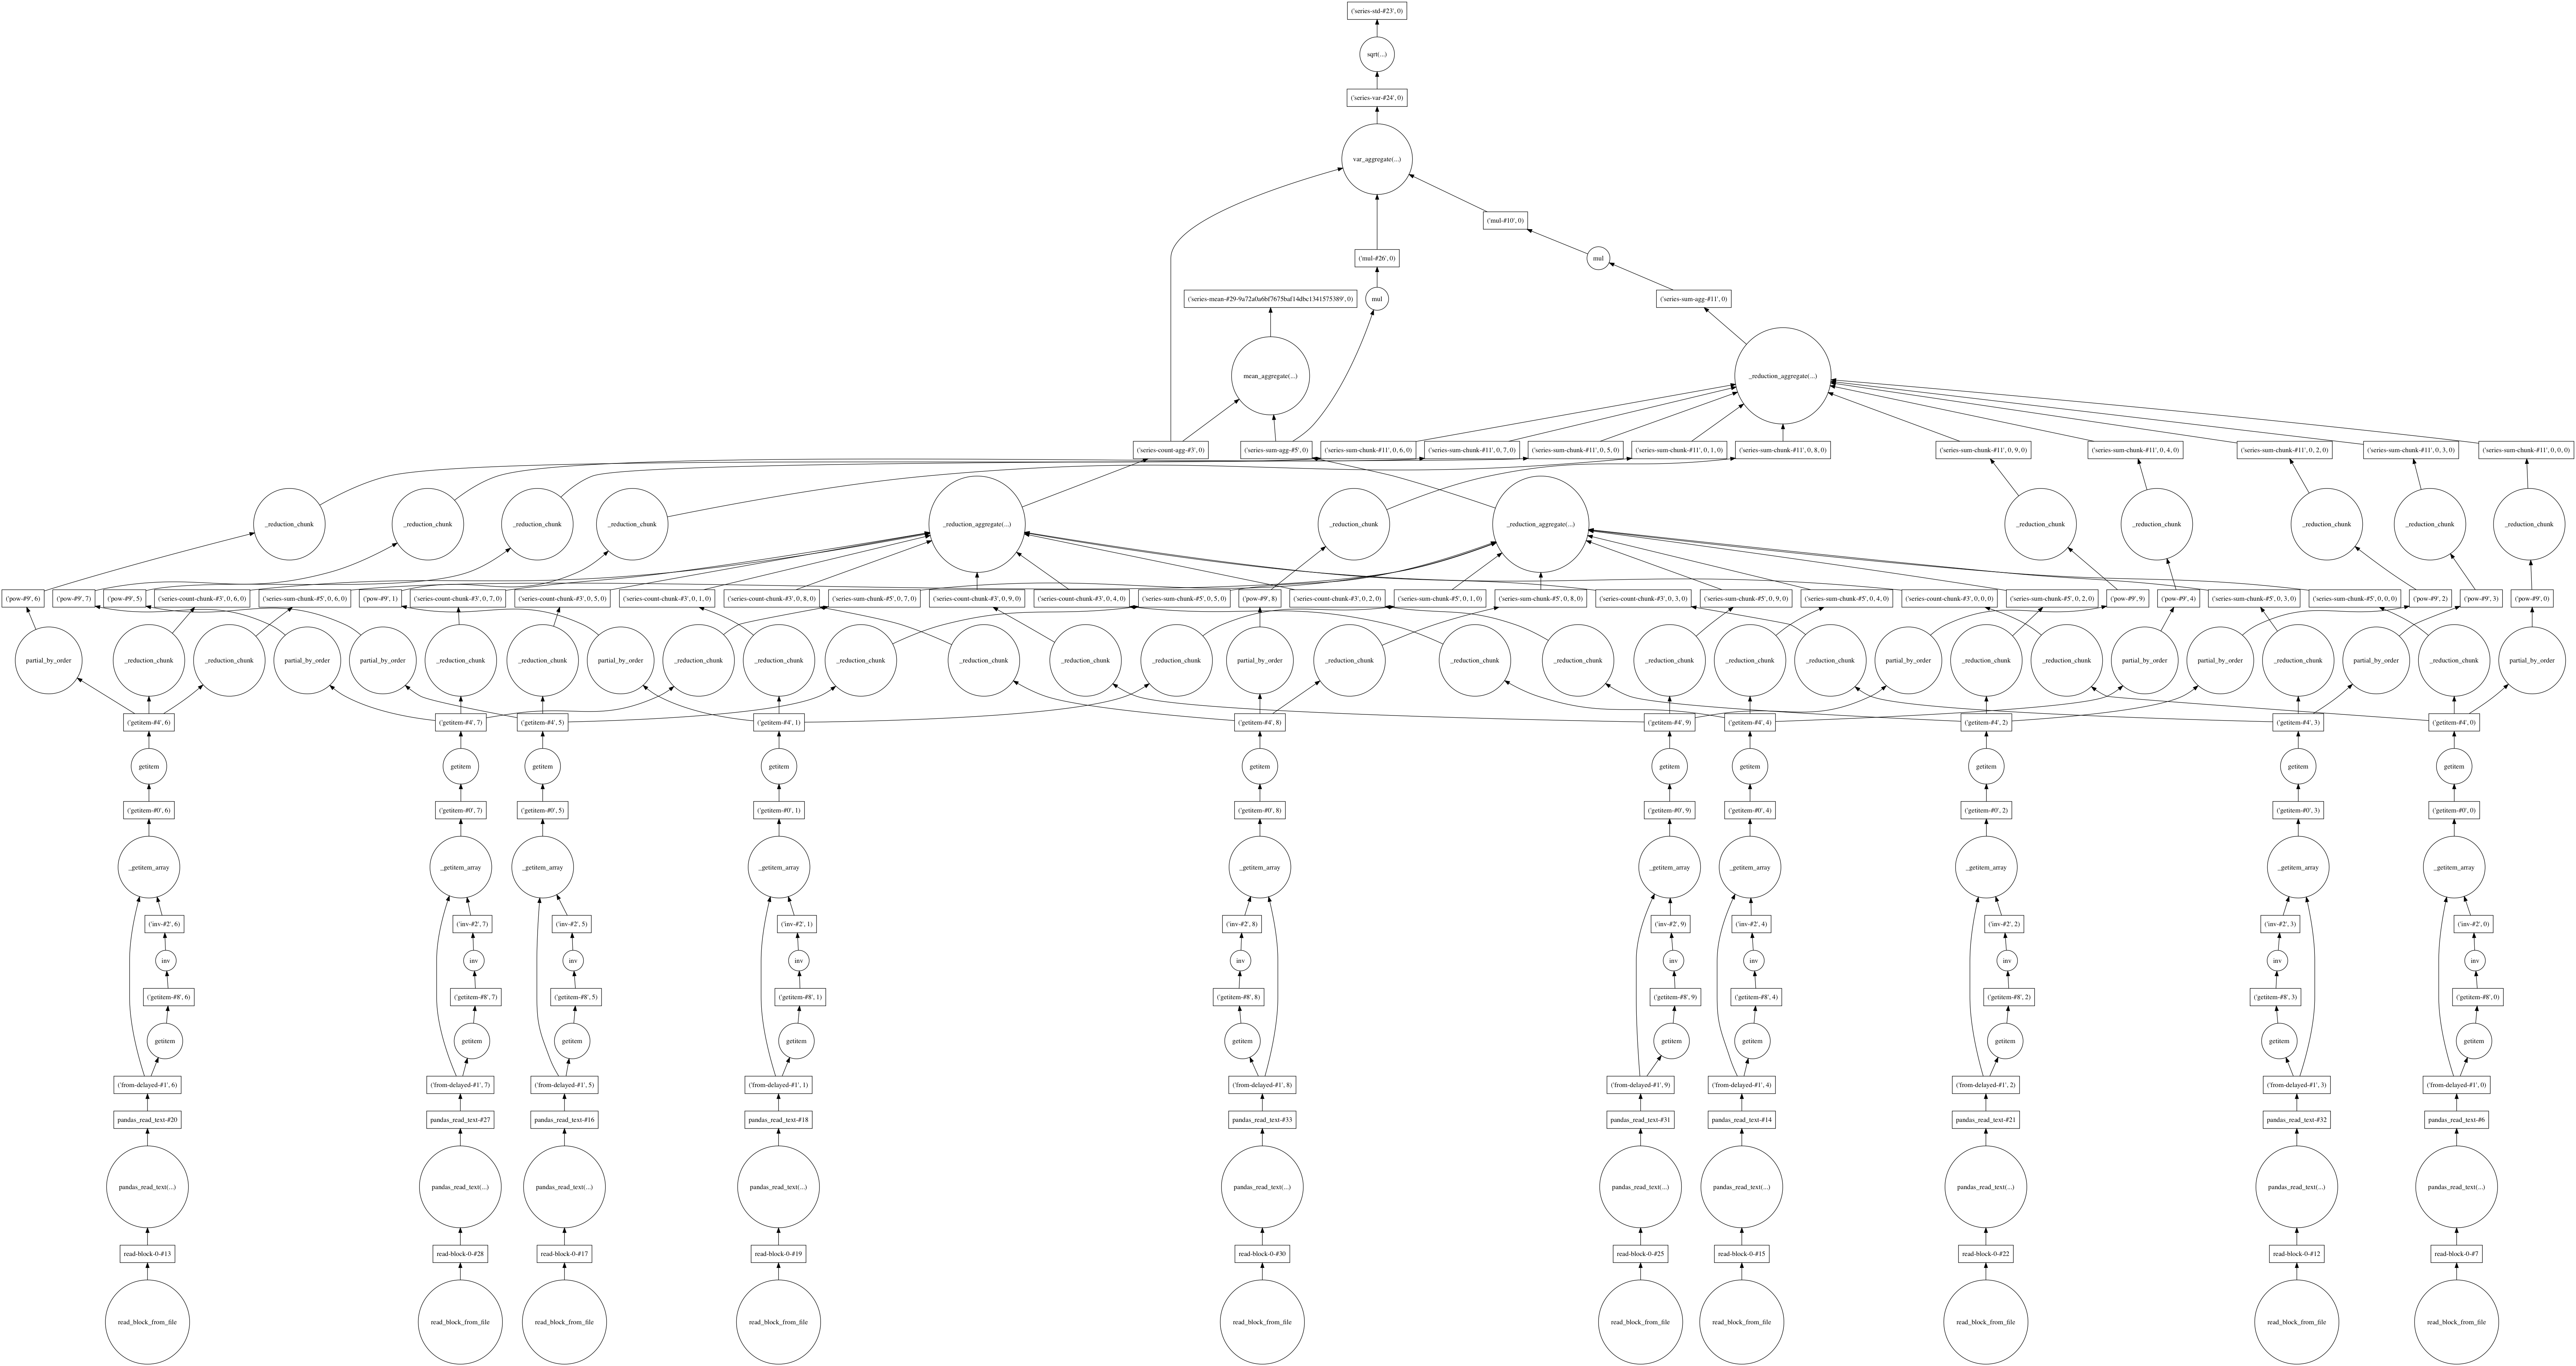

In [45]:
dask.visualize(mean_delay, std_delay) #takes are argument of filename and will save out viz to that.

## Converting `CRSDepTime` to a timestamp

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [46]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [47]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [48]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

### Custom code and Dask Dataframe

Unfortunately, `dask.dataframe` currently lacks the `to_timestamp` function. In general `dask.dataframe` tries hard to emulate the Pandas api (or at least the most commonly used subset of it),  but sometimes a method/function you need won't be implemented (yet), or you need to do some custom operation that there isn't a method for.

To make this easier, `dask.dataframe` provides a few methods for implementing common patterns:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timestamp` on our own:

In [49]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

Help on method map_partitions in module dask.dataframe.core:

map_partitions(self, func, *args, **kwargs) method of dask.dataframe.core.Series instance
    Apply Python function on each DataFrame partition.
    
    Note that the index and divisions are assumed to remain unchanged.
    
    Parameters
    ----------
    func : function
        Function applied to each partition.
    args, kwargs :
        Arguments and keywords to pass to the function. The partition will
        be the first argument, and these will be passed *after*.
    meta : pd.DataFrame, pd.Series, dict, iterable, tuple, optional
        An empty ``pd.DataFrame`` or ``pd.Series`` that matches the dtypes
        and column names of the output. This metadata is necessary for
        many algorithms in dask dataframe to work.  For ease of use, some
        alternative inputs are also available. Instead of a ``DataFrame``,
        a ``dict`` of ``{name: dtype}`` or iterable of ``(name, dtype)``
        can be provided

In [50]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [51]:
departure_timestamp

Dask Series Structure:
npartitions=10
None    datetime64[ns]
None               ...
             ...      
None               ...
None               ...
dtype: datetime64[ns]
Dask Name: add, 110 tasks

In [52]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

### Exercise: Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [53]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)

In [54]:
departure_timestamp = df.map_partitions(compute_departure_timestamp)

In [55]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

<button data-toggle="collapse" data-target="#sol9" class='btn btn-primary'>Solution</button>
<div id="sol9" class="collapse">
```python
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
```